In [1]:
import pandas as pd
import numpy as np
import sqlite3
import re
import nltk

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from time import time

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
conn = sqlite3.connect('twitter_new.db')

In [155]:
def rmv_emails_websites(string):
    """Function removes emails, websites and numbers"""
    new_str = re.sub(r"\S+@\S+", ' ', string)
    new_str = re.sub(r"\S+.co\S+", ' ', new_str)
    new_str = re.sub(r"\S+.ed\S+", ' ', new_str)
    new_str = re.sub(r"[0-9]+", ' ', new_str)
    new_str = re.sub(r"[^A-Za-z]", ' ', new_str)
    return new_str

def process_text(corpus):
    import nltk
    from nltk.corpus import stopwords 
    from nltk.tokenize import word_tokenize
    from nltk.stem.porter import PorterStemmer 
    from nltk.stem import WordNetLemmatizer
    

    stemmer = WordNetLemmatizer()

    #nltk.download('punkt')
    #nltk.download('stopwords')
    #nltk.download('wordnet')


    #remove non letters and turn to lower case
    print('Removing non A-Z a-z')
    #corp_processed =  corpus.apply(lambda x: re.sub(r'[^A-Za-z]', ' ', x.lower()))
    corp_processed =  corpus.apply(lambda x: rmv_emails_websites(x.lower()))
    corp_tokenized = corp_processed.apply(lambda x: word_tokenize(x))
    print('Removing stop words')
    for w in corp_tokenized:
        if w in stopwords.words('english'):
            corp_tokenized.remove(w)
    print('Applying autocorrect and stem word')
    for i in range(len(corp_tokenized)):
        corp_tokenized[i] = [stemmer.lemmatize((word)) for word in corp_tokenized[i]]
    print('Cleansing done')
    clean_corpus = corp_tokenized.apply(lambda x: " ".join(x))
    
    return clean_corpus

def dimensionality_reduction(tf_idf_text):
    components = tf_idf_text.shape[1] - 1
    
    lsa1 = TruncatedSVD(n_components=components)
    t0 = time()
    print(f"Start LS at {t0}")
    lsa_results1 = lsa1.fit_transform(tf_idf_text)
    explained_variance1 = lsa1.explained_variance_ratio_.sum()

    print(f"LSA done in {time() - t0:.3f} s")
    print(f"Cumulative explained variance: {explained_variance1 * 100:.1f}%")

    plt.plot(np.arange(components), lsa1.explained_variance_)
    plt.plot(np.arange(components), lsa1.explained_variance_.cumsum())
    plt.xlabel('n_components')
    plt.ylabel('explained variance')
    plt.legend(labels=['current', 'cumulative'])
    
    plt.axhline(0.9, ls='--', color='g')
    plt.show()
    
    return lsa1

# def find_optimal_clusters(data, max_k):
#     iters = range(2, max_k+1)
    
#     sse = []
#     for k in iters:
#         print(f'Fitting clusters {k}')
#         #err = MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(data).inertia_
#         err = KMeans(n_clusters=k, n_init=10, max_iter=500, random_state=20).fit(data).inertia_
#         sse.append(err)
#         print(f'Fit {k} clusters, SSE: {err}')
        
#     f, ax = plt.subplots(1, 1)
#     ax.plot(iters, sse, marker='o')
#     ax.set_xlabel('Cluster Centers')
#     ax.set_xticks(iters)
#     ax.set_xticklabels(iters)
#     ax.set_ylabel('SSE')
#     ax.set_title('SSE by Cluster Center Plot')
#     return np.argmin(sse) + 2

def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1)
    
    sse = []
    ssv = []
    for k in iters:
        print(f'Fitting clusters {k}')
        #kmean = MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(data)
        kmean = KMeans(n_clusters=k, n_init=10, max_iter=500, random_state=20).fit(data)
        err = kmean.inertia_
        cluster_labels = kmean.predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)

        sse.append(err)
        ssv.append(silhouette_avg)
        print(f'Fit {k} clusters, SSE: {err}, silhouette_score: {silhouette_avg}')

        
    f, (ax1, ax2) = plt.subplots(2, 1)
    ax1.plot(iters, sse, marker='o')
    ax1.set_xlabel('Cluster Centers')
    ax1.set_xticks(iters)
    ax1.set_xticklabels(iters)
    ax1.set_ylabel('SSE')
    ax1.set_title('SSE by Cluster Center Plot')

    ax2.plot(iters, ssv, marker='o')
    ax2.set_xlabel('Cluster Centers')
    ax2.set_xticks(iters)
    ax2.set_xticklabels(iters)
    ax2.set_ylabel('Silhoutte Average')
    ax2.set_title('Silhoutte Average by Cluster Center Plot')
    plt.tight_layout()
    
    return np.argmin(sse) + 2, np.argmax(ssv) + 2

def plot_tsne_pca(data, labels):
    print(f'Start plotting')
    print(labels)
    size = len(labels)
    max_label = max(labels)
    max_items = np.random.choice(range(data.shape[0]), size=size, replace=False)
    
    pca = PCA(n_components=2).fit_transform(data[max_items,:])

    tsne = TSNE(learning_rate='auto', init='pca').fit_transform(PCA(n_components=50).fit_transform(data[max_items,:]))
    
    idx = np.random.choice(range(pca.shape[0]), size=size, replace=False)
    label_subset = labels[max_items]
    orig_subset = label_subset
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]
    
    f, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    ax[0].set_title('PCA Cluster Plot')
    ax[0].set_xlim(-1, 1)
    ax[0].set_ylim(-1, 1)
    
    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax[1].set_title('TSNE Cluster Plot')
    
    return orig_subset, label_subset, tsne
    
def get_top_keywords(data, clusters, labels, n_terms):
    
    df = pd.DataFrame(data).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))
            
def vectorize_corpus(txt, feat=None):
    from sklearn.feature_extraction import _stop_words

    stpwrds = _stop_words.ENGLISH_STOP_WORDS.union(['ha', 'wa', 'don', 'let', 've', 'll', 'didn', 'did'])
    
    print('Start vectorization')
    tfidf = TfidfVectorizer(
        max_features = feat,
#         min_df = 10,
#         max_df = .50,
        min_df = 5,
        max_df = .80,
        stop_words = stpwrds
    )
    tfidf.fit(txt)
    text = tfidf.transform(txt)
    nonzeros = text.sum(axis=1).nonzero()[0]
    text = text[nonzeros]
    print('End vectorization')
    return text, tfidf

In [156]:
df = pd.read_sql_query("SELECT text FROM twitter_dump WHERE created_at < '2022-01-01'", conn)
df

,text
0,@levi_alterman Kind of like $CRV before it moved
1,@JoeBiden There's still time to buy #Bitcoin b...
2,@thatMTGguy88 Usually the best way to play it....
3,@JustinSiderXBT https://t.co/VFmSMLRClO has lo...
4,$BTC - Dominance keeps dropping. This is great...
...,...
24718,@_krutches That’s a good lookin swing mate
24719,@RookieXBT @Abu9ala7 @chatwithcharles @TheCryp...
24720,@ralphraudenz @garyvee @FastFoodPunks Amazing ...
24721,@RepCawthorn We do


In [157]:
txt = process_text(df.text)
txt

Removing non A-Z a-z
Removing stop words
Applying autocorrect and stem word
Cleansing done


0           levi alterman kind of like crv before it moved
1        joebiden there s still time to buy before infl...
2        thatmtgguy usually the best way to play it i k...
3                          justinsiderxbt ha lower gas fee
4        btc dominance keep dropping this is great for alt
                               ...                        
24718             krutches that s a good lookin swing mate
24719    rookiexbt abu ala chatwithcharles thecryptocac...
24720       ralphraudenz garyvee fastfoodpunks amazing bro
24721                                    repcawthorn we do
24722                               hankai yes yes yes yes
Name: text, Length: 24723, dtype: object

In [158]:
text, tfidf = vectorize_corpus(txt)
text.shape

Start vectorization
End vectorization


(23302, 4089)

Start LS at 1669906980.6446278
LSA done in 78.689 s
Cumulative explained variance: 100.0%


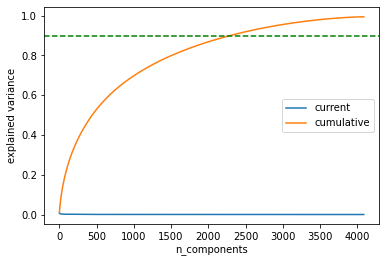

In [159]:
lsa = dimensionality_reduction(text)

In [162]:
cs = lsa.explained_variance_.cumsum()
max_bull_features = np.transpose(np.nonzero(cs >= .9))[0][0]
max_bull_features = 1505 #n_components
print(f'Bull Features Required at 90% Variance {max_bull_features}')

Bull Features Required at 90% Variance 2293


In [163]:
max_bull_features = 2293
# text, tfidf = vectorize_corpus(txt, max_bull_features)
# #text.shape

print(f"Start LSA Bull truncated to {max_bull_features}")
lsa = TruncatedSVD(n_components=max_bull_features)
# t0 = time()
text_ = lsa.fit_transform(text)
text_.shape

Start LSA Bull truncated to 2293


(23302, 2293)

Fitting clusters 2
Fit 2 clusters, SSE: 20766.46001926137, silhouette_score: 0.007386901552817682
Fitting clusters 3
Fit 3 clusters, SSE: 20706.793321008037, silhouette_score: 0.009208895920797254
Fitting clusters 4
Fit 4 clusters, SSE: 20627.560877454485, silhouette_score: 0.0009295925720989541
Fitting clusters 5
Fit 5 clusters, SSE: 20520.96875019223, silhouette_score: 0.007639891799543165
Fitting clusters 6
Fit 6 clusters, SSE: 20436.085803495014, silhouette_score: 0.0104486374701065
Fitting clusters 7
Fit 7 clusters, SSE: 20433.516025720473, silhouette_score: 0.005959464863751466
Fitting clusters 8
Fit 8 clusters, SSE: 20399.36370300235, silhouette_score: 0.004059188154002714
Fitting clusters 9
Fit 9 clusters, SSE: 20294.24370008912, silhouette_score: 0.016146257112333008
Fitting clusters 10
Fit 10 clusters, SSE: 20269.992437684683, silhouette_score: 0.010553105130686507
Fitting clusters 11
Fit 11 clusters, SSE: 20218.556180682557, silhouette_score: 0.015135371653622432


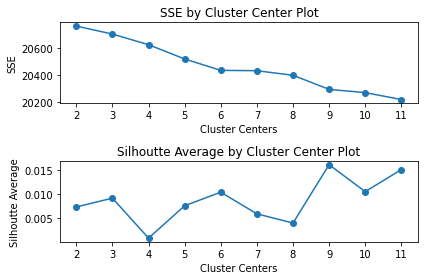

In [164]:
sse, cluster = find_optimal_clusters(text_, 11)

Start Clustering for 9
Start plotting
[3 3 3 ... 3 3 4]


C:\Users\rozzb\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


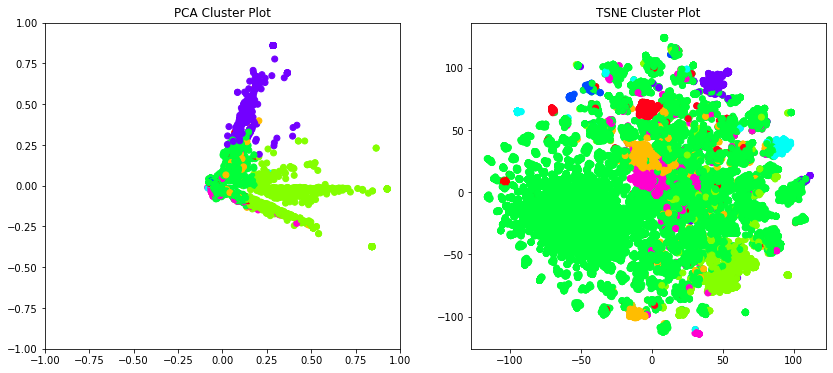

In [185]:
#clusters = MiniBatchKMeans(n_clusters=cluster, init_size=1024, batch_size=2048, random_state=20).fit_predict(text)

print(f'Start Clustering for {cluster}')
kmeans = KMeans(n_clusters=cluster, n_init=10, max_iter=500, random_state=20)
clusters = kmeans.fit_predict(text_)
label_bull, cm_bull, tsne_bull =  plot_tsne_pca(text_, clusters)

In [168]:
#get_top_keywords(text, clusters, tfidf.get_feature_names_out(), 15)

original_space_centroids = lsa.inverse_transform(kmeans.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]
terms = tfidf.get_feature_names_out()

for i in range(cluster):
    print(f"Cluster {i}: ", end="")
    for ind in order_centroids[i, :15]:
        print(f"{terms[ind]} ", end="")
    print()

Cluster 0: legend birb crypto cryptomichnl follow dougboneparth cryptokaleo absolute live trillionusd thank true friend kevinsvenson truecrypto 
Cluster 1: going update subscribe forget check live new youtube today market time btc fresh just think 
Cluster 2: btc crypto new time close high resistance market day like bull area month video support 
Cluster 3: just time like crypto lol look think nice people thanks market eth day love know 
Cluster 4: yes sir ahh jclcapital kevinsvenson just crypto market jesseolson usually right short parabolic time think 
Cluster 5: lmao ladyofcrypto trader pentosh crypto following elonmusk pic sz kevinsvenson king cryptoyurii understand chart gm 
Cluster 6: birb crypto caesar brother theo lol thank wclementeiii man thanks cryptomichnl respect trader verified nice 
Cluster 7: good morning run look looking feel far time entry really like luck thing today just 
Cluster 8: yeah oh lol boy just like wow think good shit pretty people know love stop 


In [169]:
from collections import Counter
#clusters = KMeans(n_clusters=10, n_init=10, max_iter=500, random_state=20).fit_predict(text)
Counter(np.sort(clusters))

Counter({0: 74,
         1: 810,
         2: 1369,
         3: 19134,
         4: 287,
         5: 163,
         6: 353,
         7: 784,
         8: 328})

[3, 1, 8, 7, 5, 2, 0, 6, 4]
[array([36.649418, 37.18305 ], dtype=float32), array([   2.16445, -101.01962], dtype=float32), array([57.40831 , 61.245342], dtype=float32), array([ -5.203154, -10.966841], dtype=float32), array([-39.73224,  82.68896], dtype=float32), array([ 68.03249 , -55.129345], dtype=float32), array([-87.00336 ,  26.080378], dtype=float32), array([43.760277, 79.17738 ], dtype=float32), array([-96.53137 ,  63.109257], dtype=float32)]


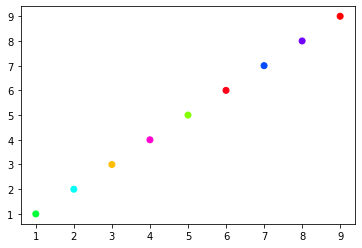

In [182]:
indexes = np.unique(label_bull, return_index=True)[1]
print([label_bull[index] for index in sorted(indexes)])
print([tsne_bull[index] for index in sorted(indexes)])

cm_bull_dist = []
seen = set()
for item in cm_bull:
    if item not in seen:
        cm_bull_dist.append(item)
        seen.add(item)
rng = np.arange(1, cluster+1)
plt.scatter(rng, rng, c=cm_bull_dist)

In [171]:
df_new = pd.read_sql_query("SELECT text FROM twitter_dump WHERE created_at > '2022-01-01'", conn)
df_new

,text
0,@CryptoAnarchyst @NekozTek You haven't tried s...
1,"@inmortalcrypto Simple, I like it"
2,@ImNotTheWolf The only good thing about bad ac...
3,@CryptoSausage @SatoshiFlipper @gigaswapfinanc...
4,@SatoshiFlipper Best deal I've found is #Bitco...
...,...
15265,@RookieXBT Ahhhh I can’t wait 🔥
15266,@LordBogdanoff Send me naked pic \nHello\nBitc...
15267,@LordBogdanoff @BrianBettor Yea why do you thi...
15268,@CryptoCX1 @ClownWorld_ You can’t put 10% down...


In [172]:
txt_new = process_text(df_new.text)

Removing non A-Z a-z
Removing stop words
Applying autocorrect and stem word
Cleansing done


In [173]:
text_new, tfidf_new = vectorize_corpus(txt_new)

Start vectorization
End vectorization


Start LS at 1669907642.4395938
LSA done in 34.889 s
Cumulative explained variance: 100.0%


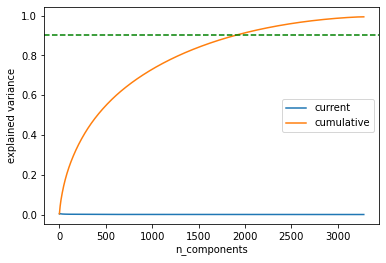

In [174]:
lsa_new = dimensionality_reduction(text_new)

In [175]:
cs_new = lsa_new.explained_variance_.cumsum()
max_bear_features = np.transpose(np.nonzero(cs_new >= .9))[0][0]
max_bear_features = 1018 #n_components
print(f'Bear Features Required at 90% Variance {max_bear_features}')


Bear Features Required at 90% Variance 1890


In [176]:
max_bear_features = 1890
print(f"Start LSA Bear truncated to {max_bear_features}")
lsa_new = TruncatedSVD(n_components=max_bear_features)
# t0 = time()
text_new_ = lsa_new.fit_transform(text_new)
text_new_.shape


Start LSA Bear truncated to 1890


(14503, 1890)

Fitting clusters 2
Fit 2 clusters, SSE: 12962.928027607782, silhouette_score: -0.0013107266184916068
Fitting clusters 3
Fit 3 clusters, SSE: 12898.442252423498, silhouette_score: 0.0013017613641876484
Fitting clusters 4
Fit 4 clusters, SSE: 12883.777741947446, silhouette_score: 0.0007973391384846237
Fitting clusters 5
Fit 5 clusters, SSE: 12815.871137081871, silhouette_score: 0.00422391842034863
Fitting clusters 6
Fit 6 clusters, SSE: 12777.002628506987, silhouette_score: 0.0039027688616726924
Fitting clusters 7
Fit 7 clusters, SSE: 12741.211740146055, silhouette_score: 0.005774289618083335
Fitting clusters 8
Fit 8 clusters, SSE: 12719.300914473886, silhouette_score: 0.00643788502073002
Fitting clusters 9
Fit 9 clusters, SSE: 12646.769940104781, silhouette_score: 0.008143703736620876
Fitting clusters 10
Fit 10 clusters, SSE: 12640.239438150618, silhouette_score: 0.010867004476674786
Fitting clusters 11
Fit 11 clusters, SSE: 12613.821761279158, silhouette_score: 0.009639368487411794


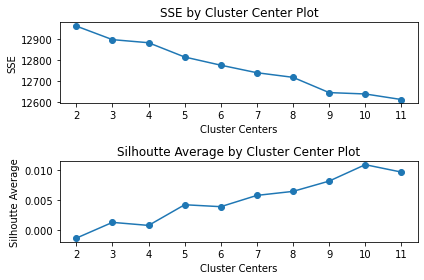

In [177]:
sse_new , cluster_new = find_optimal_clusters(text_new_, 11)

In [178]:
print(f'Start Clustering for {cluster_new}')
kmeans_new = KMeans(n_clusters=cluster_new, n_init=10, max_iter=500, random_state=20)
clusters_new = kmeans_new.fit_predict(text_new_)
print(f'Done Cluster')

Start Clustering for 10
Done Cluster


Start plotting
[5 6 5 ... 5 5 5]


C:\Users\rozzb\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


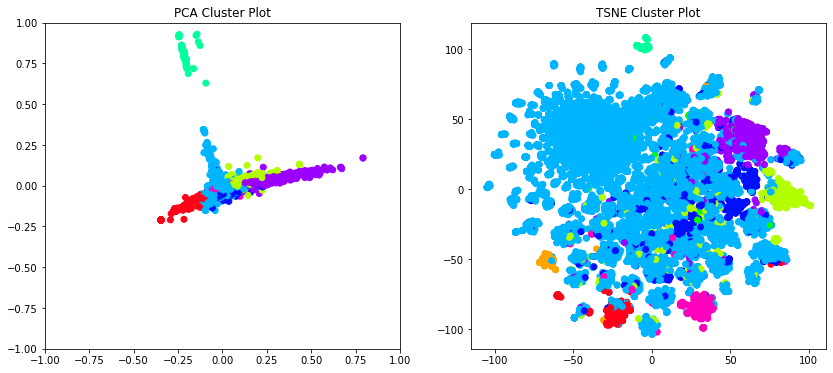

In [180]:
label_bear, cm_bear, tsne_bear = plot_tsne_pca(text_new_, clusters_new)

In [179]:
#get_top_keywords(text_new, clusters_new, tfidf_new.get_feature_names_out(), 15)

original_space_centroids = lsa_new.inverse_transform(kmeans_new.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]
terms = tfidf_new.get_feature_names_out()

for i in range(cluster_new):
    print(f"Cluster {i}: ", end="")
    for ind in order_centroids[i, :15]:
        print(f"{terms[ind]} ", end="")
    print()

Cluster 0: nuke day turbo inverse justinbennettfx just btc button garbage coindesk lol like right market short 
Cluster 1: pentosh algodtrading dont ok people sold bought thanks money actually like low funny meet damn 
Cluster 2: crypto timeless bitlord market bitboy birb stock head theo iso twitter time going right day 
Cluster 3: spx gap stock future lower btc resistance dxy october week like way right bounce midtermrally 
Cluster 4: rrgresearch cmtassociation techcharts dkellercmt mtimpane michaelnausscmt mikemcglone thebirbnest thanks thx dzi ki cheer crypto thank 
Cluster 5: good time just market people day nebraskangooner ftx today going trader year think nice make 
Cluster 6: like look just feel people time trade looking chart stock market day year good support 
Cluster 7: btc crypto amp market eth price bear low new day long newsletter resistance support today 
Cluster 8: lol nebraskangooner just like time profit yeah people said astrocryptoguru month lue good crypto got 
Clust

In [90]:
from collections import Counter
Counter(np.sort(clusters_new))

Counter({0: 770,
         1: 411,
         2: 109,
         3: 654,
         4: 11042,
         5: 93,
         6: 541,
         7: 76,
         8: 265,
         9: 286})

[5, 6, 7, 8, 2, 1, 9, 0, 4, 3]
[array([  8.802982, -24.201578], dtype=float32), array([60.44436 , -9.136778], dtype=float32), array([70.9369  , 23.666214], dtype=float32), array([ 38.38096, -78.2806 ], dtype=float32), array([75.94018 , 11.677122], dtype=float32), array([-67.23588 , -50.632465], dtype=float32), array([-24.355387, -86.91204 ], dtype=float32), array([-9.081127, 31.237768], dtype=float32), array([ -9.389506, 102.6029  ], dtype=float32), array([ 24.048006, -19.545746], dtype=float32)]


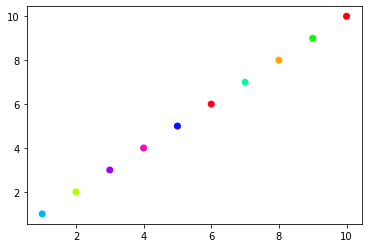

In [184]:
indexes = np.unique(label_bear, return_index=True)[1]
print([label_bear[index] for index in sorted(indexes)])
print([tsne_bear[index] for index in sorted(indexes)])
cm_bear_dist = []
seen = set()
for item in cm_bear:
    if item not in seen:
        cm_bear_dist.append(item)
        seen.add(item)

rng = np.arange(1, cluster_new+1)

plt.scatter(rng, rng, c=cm_bear_dist)


In [80]:
df_full = pd.read_sql_query("SELECT text FROM twitter_dump", conn)
df_full

,text
0,@levi_alterman Kind of like $CRV before it moved
1,@JoeBiden There's still time to buy #Bitcoin b...
2,@thatMTGguy88 Usually the best way to play it....
3,@JustinSiderXBT https://t.co/VFmSMLRClO has lo...
4,$BTC - Dominance keeps dropping. This is great...
...,...
39988,@RookieXBT Ahhhh I can’t wait 🔥
39989,@LordBogdanoff Send me naked pic \nHello\nBitc...
39990,@LordBogdanoff @BrianBettor Yea why do you thi...
39991,@CryptoCX1 @ClownWorld_ You can’t put 10% down...


In [81]:
txt_full = process_text(df_full.text)
txt_full

Removing non A-Z a-z
Removing stop words
Applying autocorrect and stem word
Cleansing done


0           levi alterman kind of like crv before it moved
1        joebiden there s still time to buy before infl...
2        thatmtgguy usually the best way to play it i k...
3                          justinsiderxbt ha lower gas fee
4        btc dominance keep dropping this is great for alt
                               ...                        
39988                         rookiexbt ahhhh i can t wait
39989    lordbogdanoff send me naked pic hello bitch la...
39990    lordbogdanoff brianbettor yea why do you think...
39991    cryptocx clownworld you can t put down on a ju...
39992     bneiluj you know boston dynamic is all cgi right
Name: text, Length: 39993, dtype: object

In [82]:
text_full, tdidf_full = vectorize_corpus(txt_full)
text_full.shape

Start vectorization
End vectorization


(37531, 3509)

Start LS at 1669889330.7719493
LSA done in 56.223 s
Cumulative explained variance: 100.0%


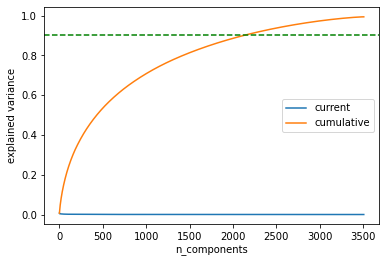

In [83]:
lsa_full = dimensionality_reduction(text_full)

In [84]:
# explained_variance1 = lsa_full.explained_variance_ratio_.sum()

# print(f"Cumulative explained variance: {explained_variance1 * 100:.1f}%")
# components = text_full.shape[1] - 1
# plt.plot(np.arange(components), lsa_full.explained_variance_)
# plt.plot(np.arange(components), lsa_full.explained_variance_.cumsum())
# plt.xlabel('n_components')
# plt.ylabel('explained variance')
# plt.legend(labels=['current', 'cumulative'])

# plt.axhline(0.9, ls='--', color='g')
# plt.show()

In [85]:
cs_full = lsa_full.explained_variance_.cumsum()
max_features = np.transpose(np.nonzero(cs_full >= .9))[0][0]
print(f'Max Features Required at 90% Variance {max_features}')

Max Features Required at 90% Variance 2122


In [1]:
"Max Features Required at 90% Variance 9697"

'Max Features Required at 90% Variance 9697'

In [96]:
max_features = 2122
print(f"Start LSA truncated to {max_features}")
lsa_full = TruncatedSVD(n_components=max_features)
# t0 = time()
text_full_ = lsa_full.fit_transform(text_full)
text_full_.shape

Start LSA truncated to 2122


(37531, 2122)

Fitting clusters 2
Fit 2 clusters, SSE: 33474.82798348888, silhouette_score: 0.004245280238141727
Fitting clusters 3
Fit 3 clusters, SSE: 33322.322024112575, silhouette_score: 0.005849623760481679
Fitting clusters 4
Fit 4 clusters, SSE: 33253.35245872762, silhouette_score: 0.004917672804401365
Fitting clusters 5
Fit 5 clusters, SSE: 33140.783198848374, silhouette_score: 0.008225665335832513
Fitting clusters 6
Fit 6 clusters, SSE: 33080.25941838267, silhouette_score: 0.008749599467867325
Fitting clusters 7
Fit 7 clusters, SSE: 32964.68398662785, silhouette_score: 0.006350663567104596
Fitting clusters 8
Fit 8 clusters, SSE: 32830.78386295546, silhouette_score: 0.010157448952841777
Fitting clusters 9
Fit 9 clusters, SSE: 32828.707298072695, silhouette_score: 0.0032951134208981155
Fitting clusters 10
Fit 10 clusters, SSE: 32686.983166590548, silhouette_score: 0.011020307644002806
Fitting clusters 11
Fit 11 clusters, SSE: 32594.80496857101, silhouette_score: 0.010196456381750004


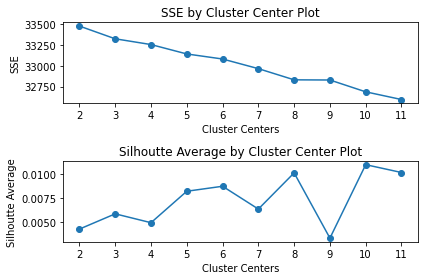

In [97]:
sse_all, cluster_all = find_optimal_clusters(text_full_, 11)

In [130]:
print(f'Start Clustering')
kmeans_full = KMeans(n_clusters=cluster_all, n_init=10, max_iter=500, random_state=20)
clusters_all = kmeans_full.fit_predict(text_full_)
print(f'End Clustering')

Start Clustering
End Clustering


Start plotting
[7 2 9 ... 7 7 9]


C:\Users\rozzb\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


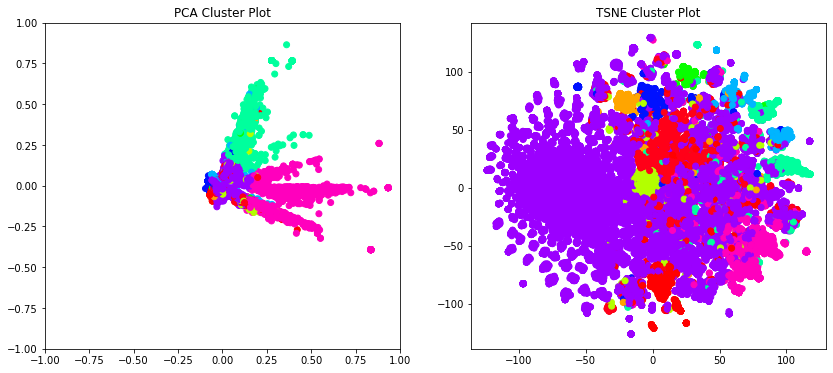

In [134]:
label_all, cm_all, tsne_all = plot_tsne_pca(text_full_, clusters_all)

In [131]:
original_space_centroids = lsa_full.inverse_transform(kmeans_full.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]
terms = tdidf_full.get_feature_names_out()

for i in range(cluster_all):
    print(f"Cluster {i}: ", end="")
    for ind in order_centroids[i, :15]:
        print(f"{terms[ind]} ", end="")
    print()

Cluster 0: good morning look run looking luck time thing feel far day friend today just really 
Cluster 1: yeah lol just like oh nebraskangooner got think people crypto sure time good buy pretty 
Cluster 2: buy dip sell btc time signal just goon people don ll like amp price spot 
Cluster 3: sir send ty thank lfg yes good crypto murfski theo byzgeneral just work trader timeless 
Cluster 4: crypto birb timeless theo bitlord joey caesar bitboy market ethereum time eth trader like iso 
Cluster 5: thanks man thank appreciate great brother sharing crypto hear happy awesome love friend pleasure support 
Cluster 6: lol like just nebraskangooner time people don said going thing got ve jesseolson tweet know 
Cluster 7: just like time look market going day yes nice let ve today ll got lmao 
Cluster 8: btc crypto new market time resistance close day eth bear high support price like bull 
Cluster 9: don people know think just like time want make money forget market trade need going 


In [132]:
from collections import Counter
Counter(np.sort(clusters_all))

Counter({0: 1156,
         1: 386,
         2: 751,
         3: 323,
         4: 1204,
         5: 689,
         6: 718,
         7: 27642,
         8: 2029,
         9: 2633})

[7, 8, 5, 9, 4, 0, 6, 1, 3, 2]
10


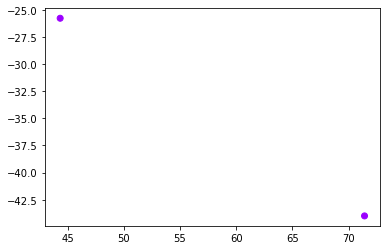

In [152]:
indexes = np.unique(label_all, return_index=True)[1]
print([label_all[index] for index in sorted(indexes)])


rng = np.arange(0, 30)
cm_all_dist = []
seen = set()
for item in cm_all:
    if item not in seen:
        cm_all_dist.append(item)
        seen.add(item)
print((cluster_all))
rng = np.arange(1, len(cm_all_dist)+1)
#plt.scatter(rng, rng, c=(cm_all_dist))
plt.scatter(tsne_all[0:2,0], tsne_all[0:2,1], c=(cm_all[0:2]))

In [52]:
indexes = np.unique(cm_all, return_index=True)[1]
[cm_all[index] for index in sorted(indexes)]


[(0.7029398794104678, 1.0, 0.0, 1.0),
 (0.7029398794104678, 1.0, 0.0, 1.0),
 (0.7029398794104678, 1.0, 0.0, 1.0),
 (0.0, 0.062501968751969, 1.0, 1.0),
 (0.6091898794104678, 0.0, 1.0, 1.0),
 (1.0, 0.0, 0.0, 1.0),
 (0.7029398794104678, 1.0, 0.0, 1.0),
 (0.7029398794104678, 1.0, 0.0, 1.0),
 (0.7029398794104678, 1.0, 0.0, 1.0),
 (0.7029398794104678, 1.0, 0.0, 1.0),
 (0.7029398794104678, 1.0, 0.0, 1.0),
 (0.7029398794104678, 1.0, 0.0, 1.0)]

In [55]:
indexes = np.unique(label_all, return_index=True)[1]
[cm_all[index] for index in sorted(indexes)]

TypeError: only integer scalar arrays can be converted to a scalar index

In [56]:
list(set(cm_all))

[(0.7029398794104678, 1.0, 0.0, 1.0),
 (1.0, 0.0, 0.09375, 1.0),
 (0.0, 1.0, 0.617278533938476, 1.0),
 (0.0, 0.7110320290467349, 1.0, 1.0),
 (1.0, 0.0, 0.742280060294766, 1.0),
 (1.0, 0.0, 0.0, 1.0),
 (1.0, 0.6485300602947661, 0.0, 1.0),
 (0.6091898794104678, 0.0, 1.0, 1.0),
 (0.03124934374934376, 1.0, 1.3125013124790507e-06, 1.0),
 (0.0, 0.062501968751969, 1.0, 1.0)]

[2, 4, 3, 5, 1, 8, 6, 9, 7, 0]


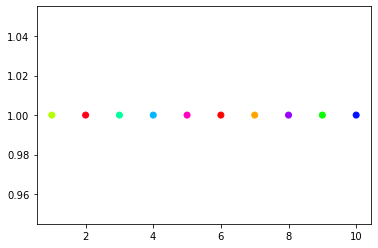

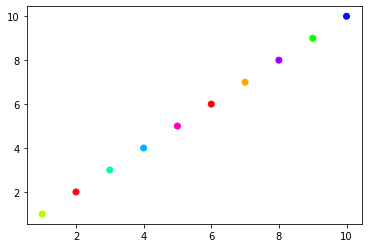

Start plotting
[3 3 3 ... 3 3 4]


AttributeError: 'function' object has no attribute 'legend_elements'

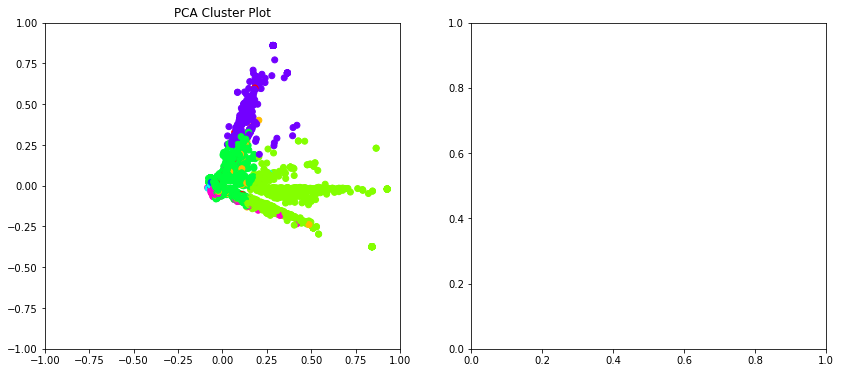

In [213]:
def plot_tsne_pca22(data, labels):
    print(f'Start plotting')
    print(labels)
    size = len(labels)
    max_label = max(labels)
    max_items = np.random.choice(range(data.shape[0]), size=size, replace=False)
    
    pca = PCA(n_components=2).fit_transform(data[max_items,:])

    #tsne = TSNE(learning_rate='auto', init='pca').fit_transform(PCA(n_components=50).fit_transform(data[max_items,:]))
    
    idx = np.random.choice(range(pca.shape[0]), size=size, replace=False)
    label_subset = labels[max_items]
    orig_subset = label_subset
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]
    
    f, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    ax[0].set_title('PCA Cluster Plot')
    ax[0].set_xlim(-1, 1)
    ax[0].set_ylim(-1, 1)
    print(ax[0].scatter.legend_elements())
    #ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    #ax[1].set_title('TSNE Cluster Plot')
    plt.show()
    return orig_subset, label_subset


label_bull, cm_bull =  plot_tsne_pca22(text_, clusters)